Лабораторна робота №3
Студента СА-43
Мозоля Назарія

Базовий код попердньої лаби

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
import itertools




# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2024-04-01 17:40:44.839502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 17:40:44.839547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 17:40:44.840332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 17:40:44.846617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 17:40:45.759351: W tensorflow/compiler/tf2

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [3]:
x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [4]:
id2class = {
    idx: name for idx, name in enumerate([
        'airplane', 'automobile', 'bird',
        'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ])
}
print(id2class)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [5]:
# def display_cifar_images(
#     x: np.ndarray,
#     y: np.ndarray,
#     id2class: dict[int, str],
#     n: int = 4
# ):
#     random_images_indices = np.random.randint(0, x.shape[0], n)
#     images = x[random_images_indices]
#     classes = [id2class[y[idx, 0]] for idx in random_images_indices]


#     f, axs = plt.subplots(1, n, figsize=((3*n, 3)))
#     for image, name, ax in zip(images, classes, axs):
#         ax.imshow(image)
#         ax.axis('off')
#         ax.set(title=f"Class: {name}")
#     plt.show()

In [6]:
# display_cifar_images(x_train, y_train, id2class)

In [7]:
class ConvBlock(tf.keras.Model):
    def __init__(self,filters: int, kernel_size: int, name: str | None = None):
        super().__init__(name=name)
        self.dense1=tf.keras.layers.Conv2D(filters,kernel_size,activation='relu',padding='same')
        self.dense2=tf.keras.layers.Conv2D(filters,kernel_size,activation='relu',padding='same')
        self.dense3=tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid')

    def call(self, inputs, training: bool):
        x = self.dense3(self.dense2(self.dense1(inputs)))
        return x


In [8]:
class ClassificationHead(tf.keras.Model):
    def __init__(self, hidden_dim: int, n_classes: int, *args, **kwargs):
        super(ClassificationHead, self).__init__(*args, **kwargs)


        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=hidden_dim/2, activation='relu')
        self.dense3 = tf.keras.layers.Dense(units=hidden_dim/4, activation='relu')
        self.out = tf.keras.layers.Dense(n_classes,activation='softmax')

    def call(self, inputs, training: bool):
        x = self.flatten(inputs)
        x = self.dense3(self.dense2(self.dense1(x)))
        return self.out(x)


In [9]:
class Cifar10Classifier(tf.keras.Model):
    def __init__(self, hidden_dim:int, n_classes:int, name: str | None = None):
        super().__init__(name=name)



        self.feature_extractor = tf.keras.Sequential(
                [
                    ConvBlock(16, 5),
                    ConvBlock(64, 3),
                    ConvBlock(128, 1),


                ],
            name='feature_extractor'
        )

       # self.pool=tf.keras.layers.GlobalMaxPooling2D()
        self.head = ClassificationHead(hidden_dim, n_classes, name='head')

    def call(self, inputs, training: bool):
        x = self.feature_extractor(inputs)
        #x = self.pool(x)
        x = self.head(x)
        return x


In [10]:
model = Cifar10Classifier(hidden_dim=1000,n_classes=len(id2class))
model.get_layer('feature_extractor')

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    run_eagerly=True
)

In [12]:
hist = model.fit(
    x=x_train,
    y=y_train,
    epochs=150,
    batch_size=512,
    validation_data=(x_test, y_test)
)

Epoch 1/150
98/98 [==============================] - 302s 3s/step - loss: 1.6801 - accuracy: 0.3890 - val_loss: 1.3566 - val_accuracy: 0.5162
Epoch 2/150
98/98 [==============================] - 301s 3s/step - loss: 1.2779 - accuracy: 0.5428 - val_loss: 1.2217 - val_accuracy: 0.5609
Epoch 3/150
98/98 [==============================] - 302s 3s/step - loss: 1.1407 - accuracy: 0.5940 - val_loss: 1.1020 - val_accuracy: 0.6089
Epoch 4/150
98/98 [==============================] - 309s 3s/step - loss: 1.0165 - accuracy: 0.6421 - val_loss: 1.0137 - val_accuracy: 0.6464
Epoch 5/150
98/98 [==============================] - 299s 3s/step - loss: 0.9062 - accuracy: 0.6822 - val_loss: 0.9666 - val_accuracy: 0.6599
Epoch 6/150
98/98 [==============================] - 301s 3s/step - loss: 0.8236 - accuracy: 0.7110 - val_loss: 0.9400 - val_accuracy: 0.6677
Epoch 7/150
98/98 [==============================] - 300s 3s/step - loss: 0.7099 - accuracy: 0.7540 - val_loss: 0.9053 - val_accuracy: 0.6923
Epoch 

In [13]:
model.summary()

Model: "cifar10_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (Sequent  (None, 29, 29, 128)       78672     
 ial)                                                            
                                                                 
 head (ClassificationHead)   multiple                  108277260 
                                                                 
Total params: 108355932 (413.35 MB)
Trainable params: 108355932 (413.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


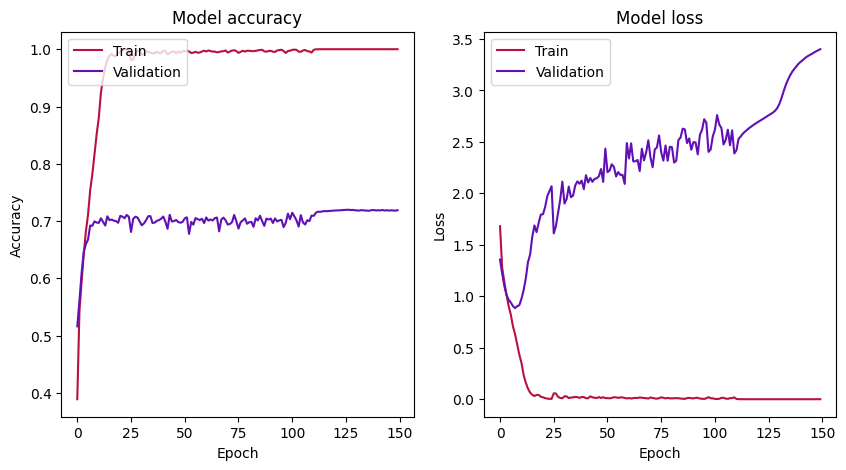

In [14]:
def plot_learning_curve(hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(hist.history['accuracy'], color='#b8113d')
    axs[0].plot(hist.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(hist.history['loss'], color='#b8113d')
    axs[1].plot(hist.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_learning_curve(hist)

In [15]:
predictions1 = model.predict(x_test)
predicted_classes1 = np.argmax(predictions1, axis=1)

313/313 [==============================] - 23s 74ms/step


In [16]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Ця функція друкує та візуалізує матрицю невідповідностей з кольорами.
    `cm`: матриця невідповідностей
    `classes`: список назв класів для відображення на осях
    `title`: заголовок для матриці
    `cmap`: колірна схема для візуалізації
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Вивід значень у квадратах
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1000
           1       0.83      0.84      0.83      1000
           2       0.64      0.59      0.61      1000
           3       0.53      0.52      0.53      1000
           4       0.67      0.63      0.65      1000
           5       0.60      0.62      0.61      1000
           6       0.76      0.79      0.77      1000
           7       0.76      0.77      0.77      1000
           8       0.82      0.85      0.84      1000
           9       0.80      0.78      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

Confusion Matrix:


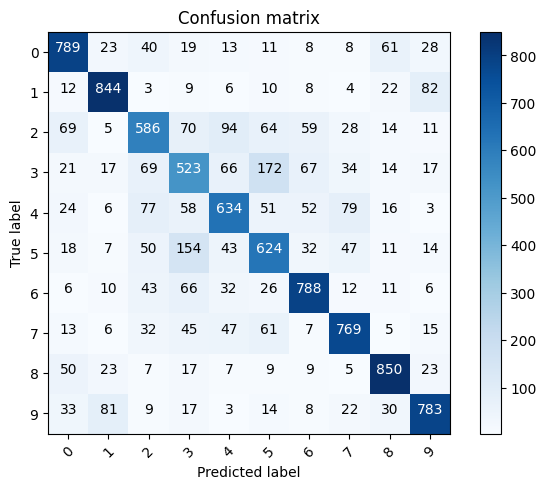

In [17]:
cr1 = classification_report(y_test, predicted_classes1)
print("Classification Report:")
print(cr1)

cm1 = confusion_matrix(y_test, predicted_classes1)
print("Confusion Matrix:")
plot_confusion_matrix(cm1, id2class.keys())

In [ ]:
# model.save('./DeepL/lab3')